In [1]:
print('hello world')

hello world


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [3]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240422_190447


Constructing DatasetFromListOfDicts:   0%|                                                                                      | 0/80 [00:00<?, ?it/s]

Calculating functional maps: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 93.48it/s]


In [4]:
from tqdm import tqdm

# data_x = test_set[15]['first']
# data_y = test_set[15]['second']

# get 15th element from test dataloader
for i, data in enumerate(tqdm(test_loader)):
    if i == 10:
        data_pair = data
        data_x = data['first']
        data_y = data['second']
        break

print('data_pair.keys()', list(data_pair.keys()))
print('data_x.keys()', list(data_x.keys()))

  2%|██▊                                                                                                              | 10/400 [00:01<00:51,  7.55it/s]

data_pair.keys() ['first', 'second', 'Cxy', 'Cyx']
data_x.keys() ['name', 'verts', 'faces', 'evecs', 'evecs_trans', 'evals', 'mass', 'L', 'corr']


In [5]:
data_pair['Cxy'].shape

torch.Size([1, 200, 200])

Cxy.shape torch.Size([200, 200])
AbsErr(Cxy @ Cxy_T, I), sum: 419.2453, mean: 0.0105
AbsErr(Cyx @ Cyx_T, I), sum: 458.4039, mean: 0.0115
AbsErr(Cxy @ Cyx, I), sum: 230.7171, mean: 0.0058
AbsErr(Cyx @ Cxy, I), sum: 238.7558, mean: 0.0060


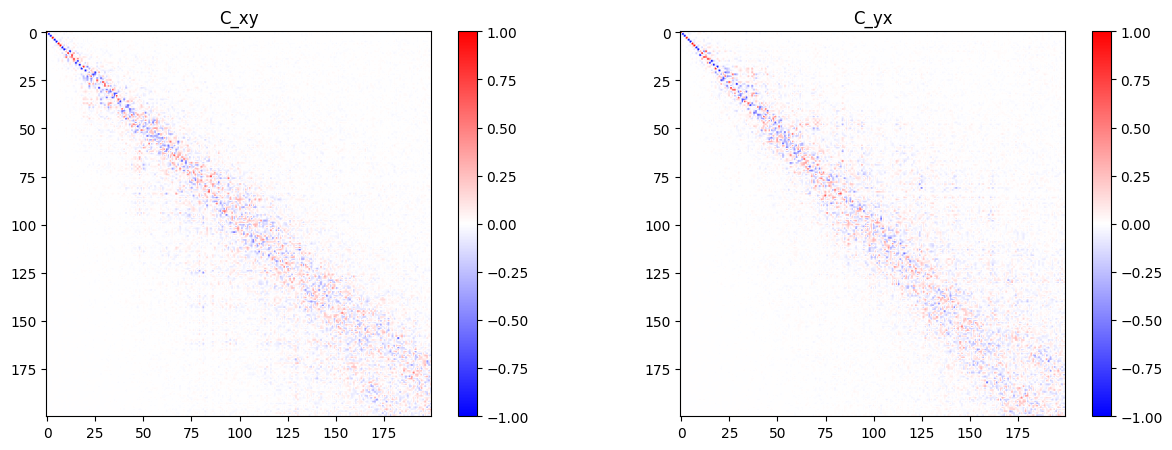

In [6]:
# plot Cxy and Cyx
import matplotlib.pyplot as plt

C_gt_xy = data_pair['Cxy'][0]
C_gt_yx = data_pair['Cyx'][0]


print('Cxy.shape', C_gt_xy.shape)

# check orthogonality for C_gt_xy and C_gt_yx
val = (C_gt_xy @ C_gt_xy.T - torch.eye(C_gt_xy.shape[0])).abs()
print(f'AbsErr(Cxy @ Cxy_T, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

val = (C_gt_yx @ C_gt_yx.T - torch.eye(C_gt_yx.shape[0])).abs()
print(f'AbsErr(Cyx @ Cyx_T, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

val = (C_gt_xy @ C_gt_yx - torch.eye(C_gt_xy.shape[0])).abs()
print(f'AbsErr(Cxy @ Cyx, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

val = (C_gt_yx @ C_gt_xy - torch.eye(C_gt_yx.shape[0])).abs()
print(f'AbsErr(Cyx @ Cxy, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

# plot them
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# C_gt_xy
C_gt_xy_plot = ax[0].imshow(C_gt_xy.cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(C_gt_xy_plot)
# ax[0].axis('off')
# ax[0].set_title('C_xy pinv')
ax[0].set_title('C_xy')

# C_gt_yx
C_gt_yx_plot = ax[1].imshow(C_gt_yx.cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(C_gt_yx_plot)
# ax[1].axis('off')
# ax[1].set_title('C_yx pinv')
ax[1].set_title('C_yx')

plt.show()

# Visualization of Cxy for one shape

In [7]:
names_y = []
Cxy_tr_reg_040 = []
Cyx_tr_reg_040 = []

train_dataset = train_loader.dataset
print(len(train_dataset))
for i in tqdm(range(len(train_dataset))):
    data = train_dataset[i]
    if data['first']['name'] == 'tr_reg_040':
        Cxy_tr_reg_040.append(data['Cxy'])
        Cyx_tr_reg_040.append(data['Cyx'])
        names_y.append(data['second']['name'])

Cxy_tr_reg_040_full = torch.stack(Cxy_tr_reg_040)
Cyx_tr_reg_040_full = torch.stack(Cyx_tr_reg_040)
    
Cxy_tr_reg_040 = torch.stack(Cxy_tr_reg_040)[:, :20, :20]
Cyx_tr_reg_040 = torch.stack(Cyx_tr_reg_040)[:, :20, :20]
    
print(Cxy_tr_reg_040.shape)
print(Cyx_tr_reg_040.shape)
print(names_y)

6400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6400/6400 [00:00<00:00, 925448.03it/s]

torch.Size([80, 20, 20])
torch.Size([80, 20, 20])
['tr_reg_000', 'tr_reg_001', 'tr_reg_002', 'tr_reg_003', 'tr_reg_004', 'tr_reg_005', 'tr_reg_006', 'tr_reg_007', 'tr_reg_008', 'tr_reg_009', 'tr_reg_010', 'tr_reg_011', 'tr_reg_012', 'tr_reg_013', 'tr_reg_014', 'tr_reg_015', 'tr_reg_016', 'tr_reg_017', 'tr_reg_018', 'tr_reg_019', 'tr_reg_020', 'tr_reg_021', 'tr_reg_022', 'tr_reg_023', 'tr_reg_024', 'tr_reg_025', 'tr_reg_026', 'tr_reg_027', 'tr_reg_028', 'tr_reg_029', 'tr_reg_030', 'tr_reg_031', 'tr_reg_032', 'tr_reg_033', 'tr_reg_034', 'tr_reg_035', 'tr_reg_036', 'tr_reg_037', 'tr_reg_038', 'tr_reg_039', 'tr_reg_040', 'tr_reg_041', 'tr_reg_042', 'tr_reg_043', 'tr_reg_044', 'tr_reg_045', 'tr_reg_046', 'tr_reg_047', 'tr_reg_048', 'tr_reg_049', 'tr_reg_050', 'tr_reg_051', 'tr_reg_052', 'tr_reg_053', 'tr_reg_054', 'tr_reg_055', 'tr_reg_056', 'tr_reg_057', 'tr_reg_058', 'tr_reg_059', 'tr_reg_060', 'tr_reg_061', 'tr_reg_062', 'tr_reg_063', 'tr_reg_064', 'tr_reg_065', 'tr_reg_066', 'tr_reg_067

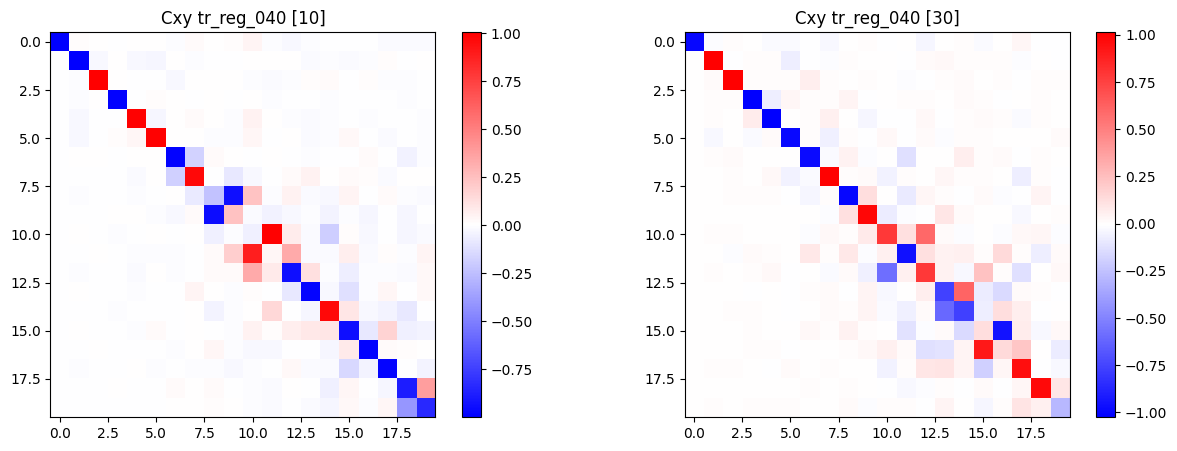

In [8]:
# plot them
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# C_gt_xy
C_gt_xy_plot = ax[0].imshow((Cxy_tr_reg_040[10][:20, :20]).cpu().numpy(), cmap='bwr')
plt.colorbar(C_gt_xy_plot)
# ax[0].axis('off')
# ax[0].set_title('C_xy pinv')
ax[0].set_title('Cxy tr_reg_040 [10]')

# C_gt_yx
C_gt_yx_plot = ax[1].imshow((Cxy_tr_reg_040[30][:20, :20]).cpu().numpy(), cmap='bwr')
plt.colorbar(C_gt_yx_plot)
# ax[1].axis('off')
# ax[1].set_title('C_yx pinv')
ax[1].set_title('Cxy tr_reg_040 [30]')

plt.show()

torch.Size([200, 200])


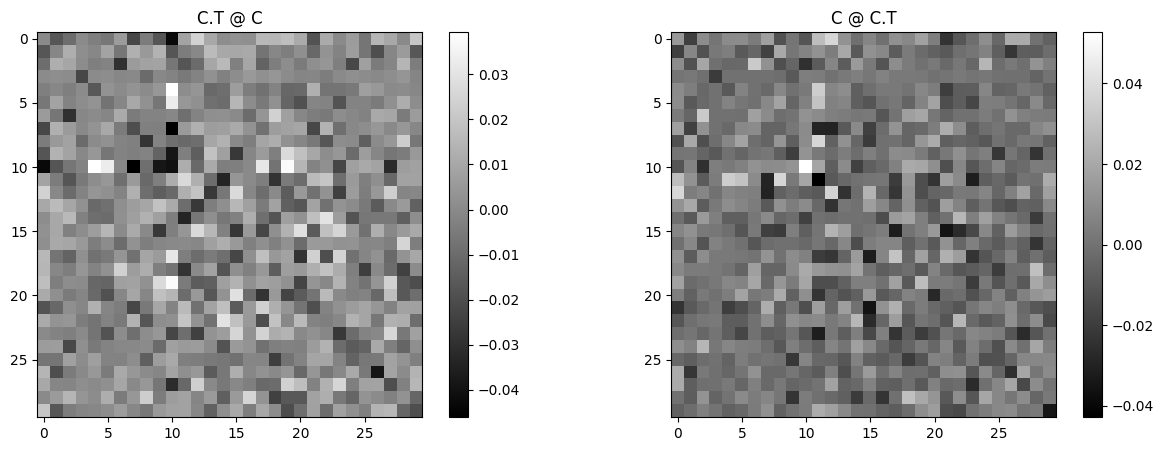

In [9]:
# plot them
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

Cxy_40_10 = Cxy_tr_reg_040_full[10]
print(Cxy_40_10.shape)
Cxy_40_10_T_Cxy_40_10 = (Cxy_40_10.T @ Cxy_40_10)[:30, :30]
Cxy_40_10_Cxy_40_10_T = (Cxy_40_10 @ Cxy_40_10.T)[:30, :30]

# C_gt_xy
Cxy_40_10_T_Cxy_40_10_plot = ax[0].imshow(Cxy_40_10_T_Cxy_40_10.cpu().numpy() - np.eye(30),
                                     cmap='gray')
plt.colorbar(Cxy_40_10_T_Cxy_40_10_plot)
# ax[0].axis('off')
# ax[0].set_title('C_xy pinv')
ax[0].set_title('C.T @ C')

# C_gt_yx
Cxy_40_10_Cxy_40_10_T_plot = ax[1].imshow(Cxy_40_10_Cxy_40_10_T.cpu().numpy() - np.eye(30), cmap='gray')
plt.colorbar(Cxy_40_10_Cxy_40_10_T_plot)
# ax[1].axis('off')
# ax[1].set_title('C_yx pinv')
ax[1].set_title('C @ C.T')

plt.show()

In [10]:
Cxy_T_Cxy_040 = torch.bmm(Cxy_tr_reg_040_full.transpose(1, 2), Cxy_tr_reg_040_full)
n_10 = Cxy_T_Cxy_040[10][:30, :30]
print((Cxy_40_10_T_Cxy_40_10 - n_10).abs().sum())

tensor(0.)


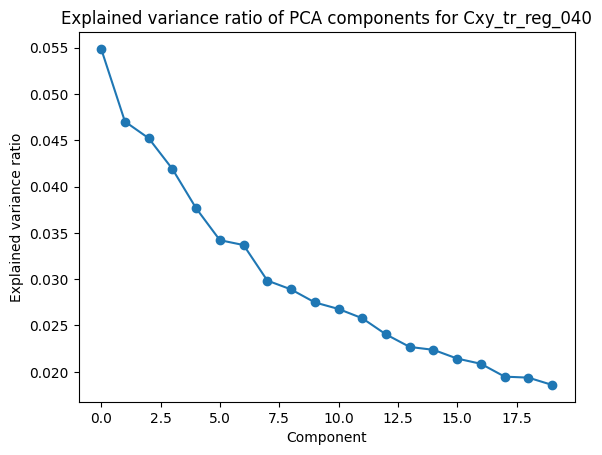

In [44]:
# apply PCA to Cxy_tr_reg_040
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=20)
scaler = StandardScaler()

Cxy_tr_reg_040_scaled = scaler.fit_transform(
    Cxy_tr_reg_040.cpu().numpy().reshape(-1, 400)
    )

Cxy_tr_reg_040_pca = pca.fit_transform(
    Cxy_tr_reg_040_scaled
    )

plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_tr_reg_040')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

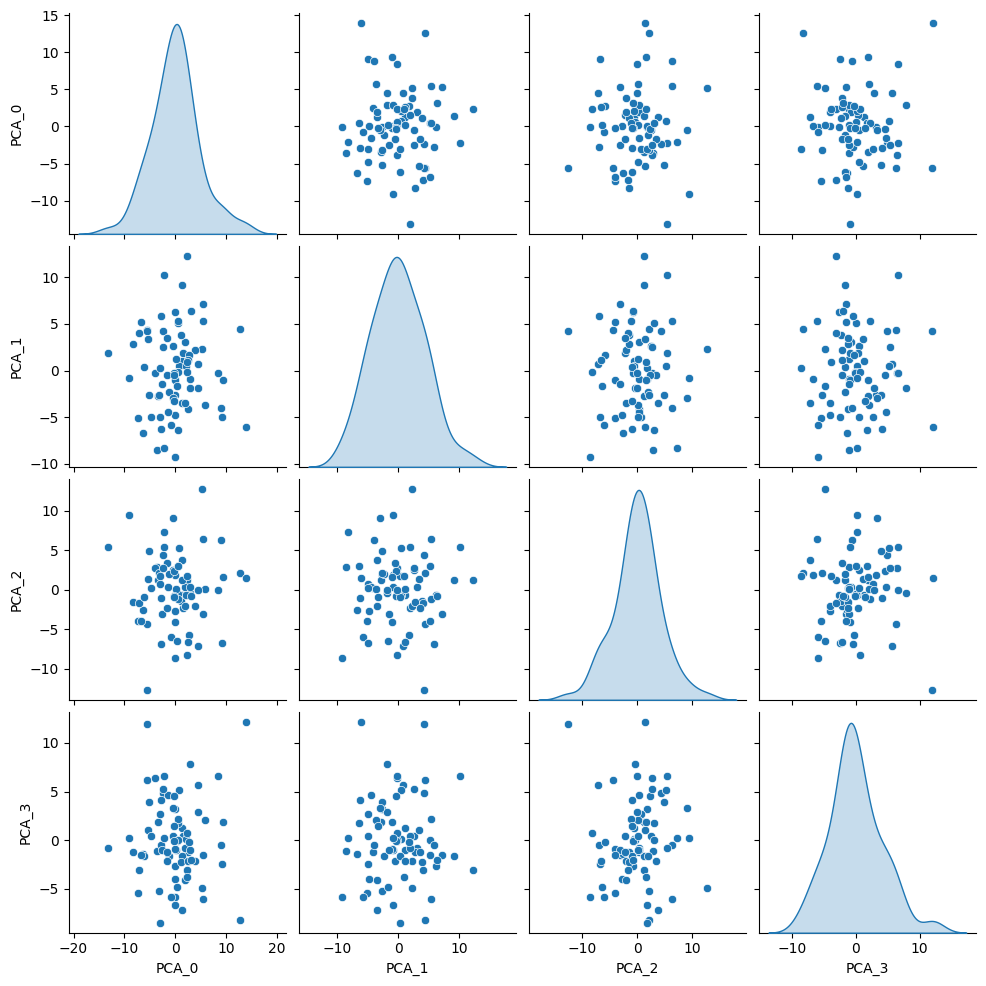

In [42]:
# plot the first 6 principal components
import seaborn as sns
import pandas as pd

pca_df = pd.DataFrame(Cxy_tr_reg_040_pca[:, :4], columns=[f'PCA_{i}' for i in range(4)])
# pca_df['name'] = names_y

sns.pairplot(pca_df, diag_kind='kde')
plt.show()

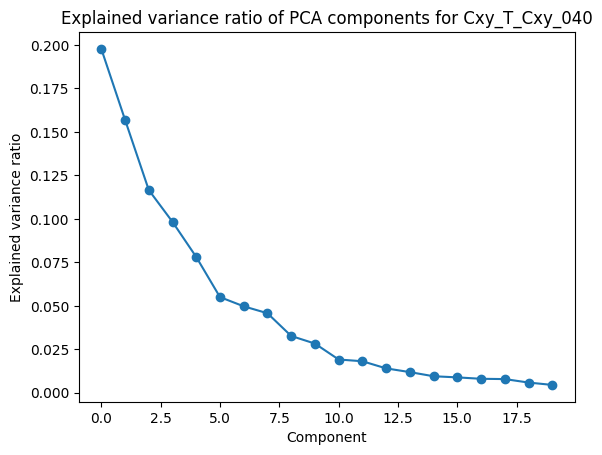

In [46]:
# apply PCA to Cxy_tr_reg_040
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=20)

scaler = StandardScaler()

Cxy_T_Cxy_040_scaled = scaler.fit_transform(Cxy_T_Cxy_040[:, :20, :20].cpu().numpy().reshape(-1, 400))

Cxy_T_Cxy_040_pca = pca.fit_transform(
    Cxy_T_Cxy_040_scaled
    )


plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_T_Cxy_040')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

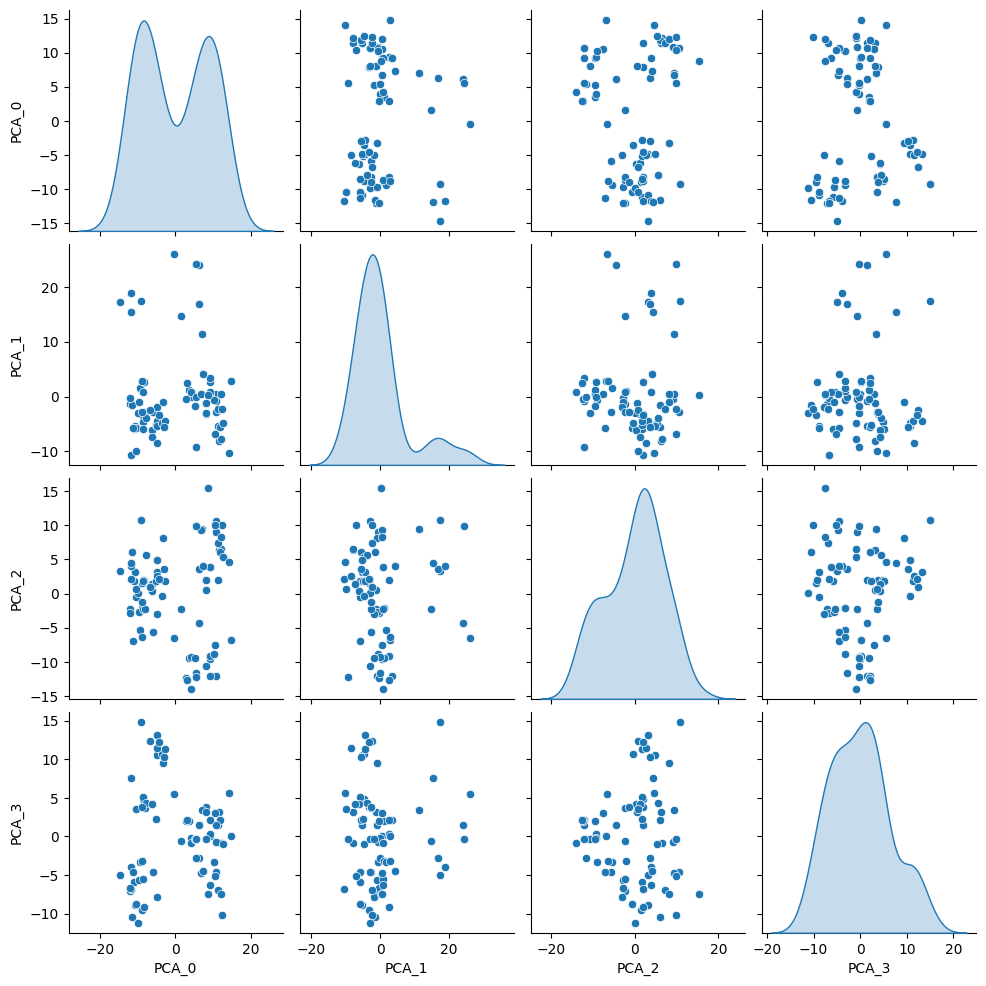

In [47]:
pca_df = pd.DataFrame(Cxy_T_Cxy_040_pca[:, :4], columns=[f'PCA_{i}' for i in range(4)])

sns.pairplot(pca_df, diag_kind='kde')
plt.show()

# Cxy for the entire dataset

In [14]:
# make color map based on name
names = [data['first']['name'] for data in train_dataset]
names_unique = np.unique(np.array(names))
colors = np.array([np.where(names_unique == name)[0][0] for name in names])

names_y = [data['second']['name'] for data in train_dataset]
colors_yx = np.array([np.where(names_unique == name)[0][0] for name in names_y])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6400/6400 [00:00<00:00, 935967.42it/s]


Cxy_full_pca.shape (6400, 20)


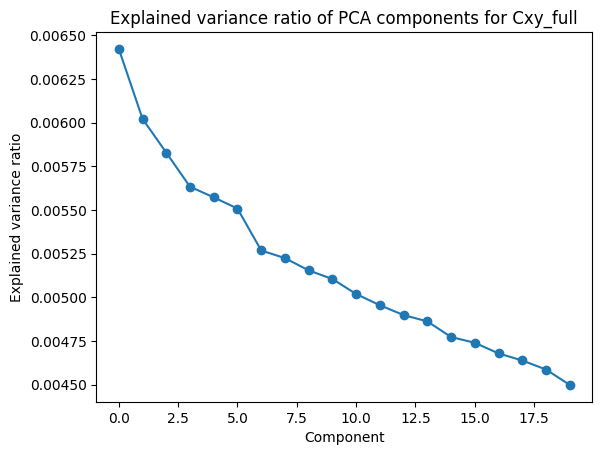

In [19]:
from sklearn.preprocessing import StandardScaler

Cxy_full = []
Cyx_full = []

for i in tqdm(range(len(train_dataset))):
    data = train_dataset[i]
    Cxy_full.append(data['Cxy'])
    Cyx_full.append(data['Cyx'])
    
Cxy_full = torch.stack(Cxy_full)[:, :20, :20]
Cyx_full = torch.stack(Cyx_full)[:, :20, :20]

pca_full = PCA(n_components=20)
scaler_full = StandardScaler()

Cxy_full_np = Cxy_full.cpu().numpy()

Cxy_full_scaled = scaler_full.fit_transform(Cxy_full_np.reshape(-1, 400))
Cxy_full_pca = pca_full.fit_transform(Cxy_full_scaled)

print('Cxy_full_pca.shape', Cxy_full_pca.shape)

plt.plot(pca_full.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_full')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

    

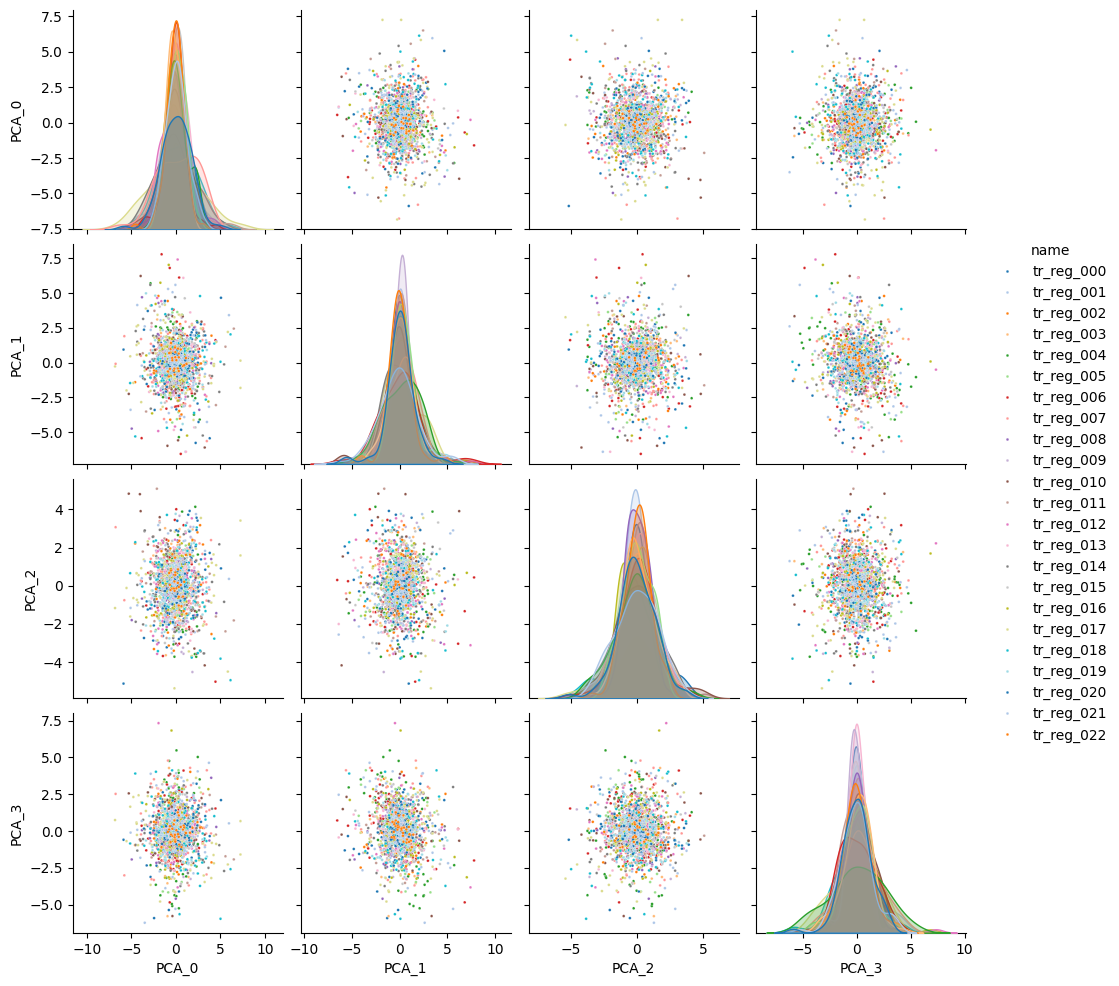

In [36]:
# plot the first 6 principal components
import seaborn as sns
import pandas as pd

pca_df = pd.DataFrame(Cxy_full_pca[:1800, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names[:1800]

sns.pairplot(pca_df, diag_kind='kde',
             hue='name', palette='tab20',
             plot_kws={'s': 4, 'alpha': 1})
plt.show()

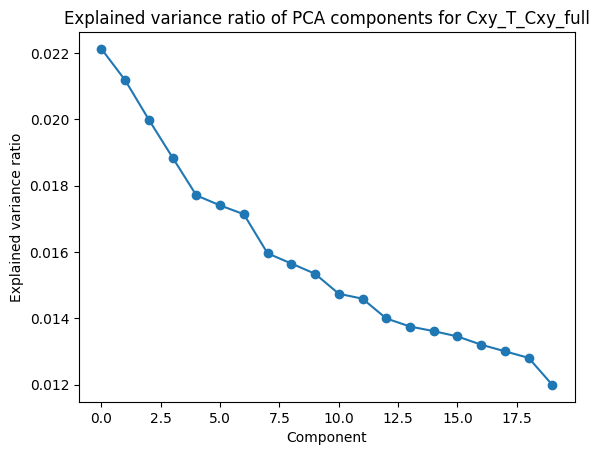

In [25]:
# import RobustScaler
from sklearn.preprocessing import RobustScaler

Cxy_T_Cxy_full = torch.bmm(Cxy_full.transpose(1, 2), Cxy_full)
Cxy_T_Cxy_full_np = Cxy_T_Cxy_full.cpu().numpy()

scaler = StandardScaler()
pca_full = PCA(n_components=20)

Cxy_T_Cxy_full_scaled = scaler.fit_transform(Cxy_T_Cxy_full_np[:, :20, :20].reshape(-1, 400))
# Cxy_T_Cxy_full_scaled = Cxy_T_Cxy_full_np[:, :20, :20].reshape(-1, 400)

Cxy_T_Cxy_full_pca = pca_full.fit_transform(Cxy_T_Cxy_full_scaled)

plt.plot(pca_full.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_T_Cxy_full')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.show()

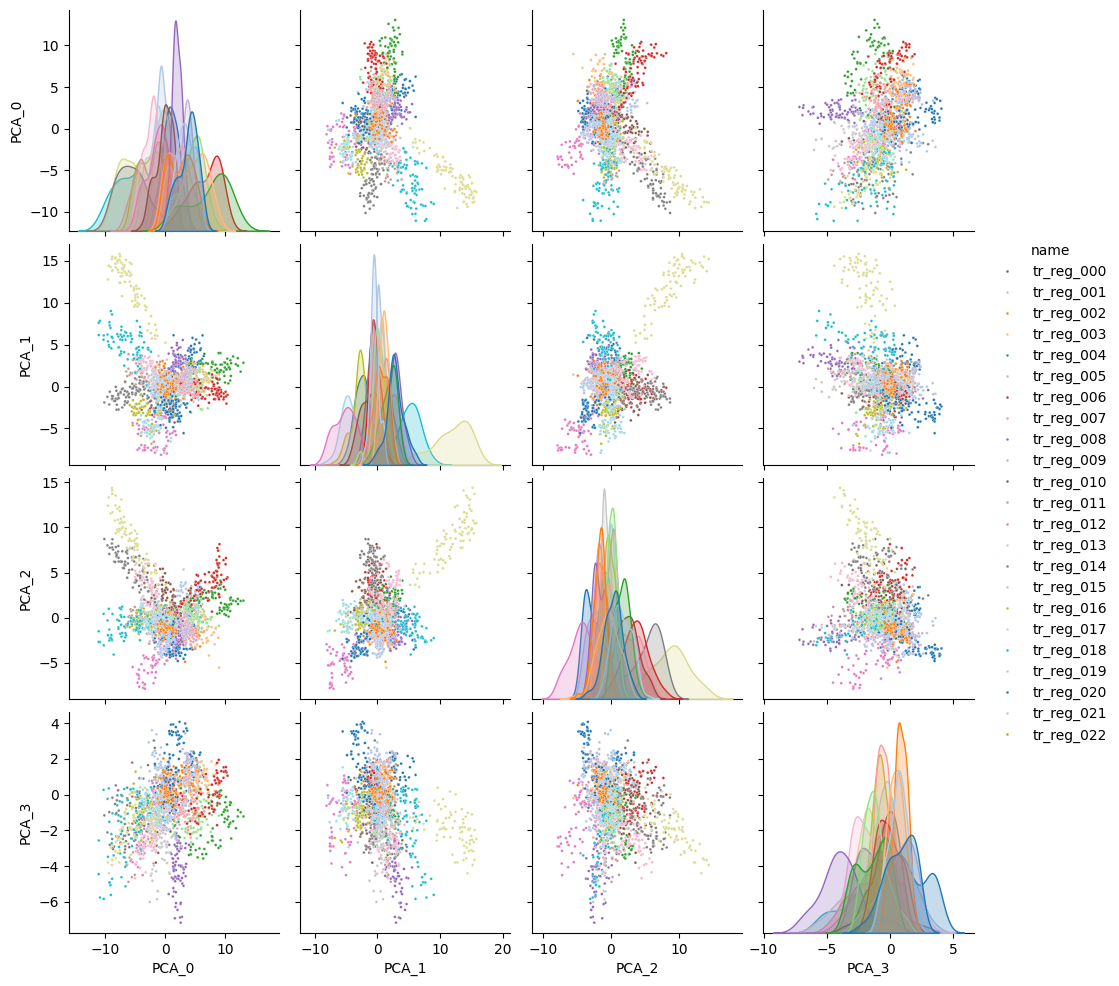

In [35]:
# plot the first 6 principal components
import seaborn as sns
import pandas as pd

pca_df = pd.DataFrame(Cxy_T_Cxy_full_pca[:1800, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names[:1800]

sns.pairplot(pca_df, diag_kind='kde',
             hue='name', palette='tab20',
             plot_kws={'s': 4, 'alpha': 1})
plt.show()

# Same with T-SNE

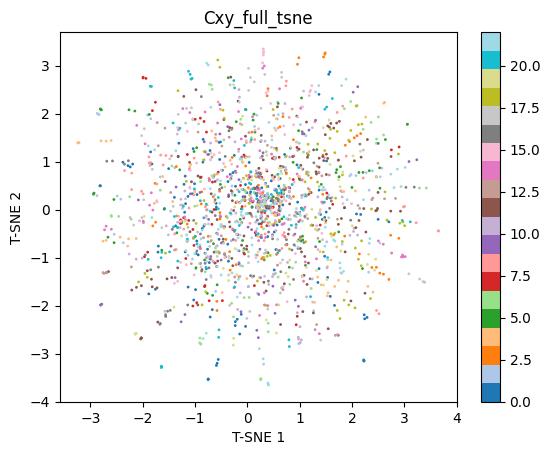

In [40]:
from sklearn.manifold import TSNE

tsne_full = TSNE(n_components=2)

Cxy_full_tsne = tsne_full.fit_transform(
    Cxy_full_scaled[:1800]
    )

plt.scatter(Cxy_full_tsne[:, 0], Cxy_full_tsne[:, 1], 
            alpha=1, c=colors[:1800], cmap='tab20', s=1)
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.title('Cxy_full_tsne')
plt.colorbar()

plt.show()


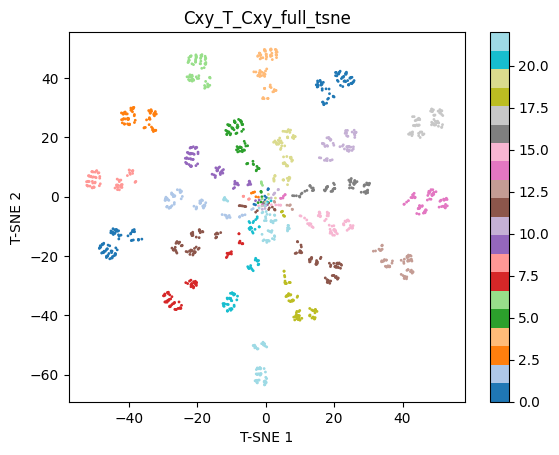

In [39]:
from sklearn.manifold import TSNE

tsne_full = TSNE(n_components=2)

Cxy_T_Cxy_full_tsne = tsne_full.fit_transform(
    Cxy_T_Cxy_full_scaled[:1800]
    )

plt.scatter(Cxy_T_Cxy_full_tsne[:, 0], Cxy_T_Cxy_full_tsne[:, 1], 
            alpha=1, c=colors[:1800], cmap='tab20', s=1, )
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.title('Cxy_T_Cxy_full_tsne')
plt.colorbar()

plt.show()


Vortex in the middle probably corresponds to area preserving, but non-conformal mappings